In [1]:
import pandas as pd

df=pd.read_csv("ccm1.csv")
df2=pd.read_csv("beta1.csv")
df.info()

C:\Users\tonyd\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143763 entries, 0 to 143762
Data columns (total 72 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   gvkey     143763 non-null  int64  
 1   datadate  143763 non-null  object 
 2   fyear     143756 non-null  float64
 3   indfmt    143763 non-null  object 
 4   consol    143763 non-null  object 
 5   popsrc    143763 non-null  object 
 6   datafmt   143763 non-null  object 
 7   tic       143761 non-null  object 
 8   cusip     143763 non-null  object 
 9   conm      143763 non-null  object 
 10  curcd     143756 non-null  object 
 11  act       104072 non-null  float64
 12  at        130850 non-null  float64
 13  bkvlps    129825 non-null  float64
 14  capx      126915 non-null  float64
 15  che       130847 non-null  float64
 16  cogs      130755 non-null  float64
 17  dcs       37557 non-null   float64
 18  dcvsr     114987 non-null  float64
 19  dcvsub    114988 non-null  float64
 20  dcvt

In [2]:
import pandas as pd
import numpy as np

# Load the data
df_ccm = pd.read_csv("ccm1.csv")

# 1. PREPARATION: Convert datadate to datetime and sort for time-series calculations
df_ccm['datadate'] = pd.to_datetime(df_ccm['datadate'])
df_ccm = df_ccm.sort_values(by=['gvkey', 'datadate']).reset_index(drop=True)

# 2. CREATE LAGGED AND AVERAGE VARIABLES (Needed for ROA, ROE, Turnovers, Growth)

# Define variables for lagged and average calculations
lag_vars = ['at', 'seq', 'sale', 'ebit', 'invt', 'rect', 'xint']
for var in lag_vars:
    # Create lag (t-1) for each variable, grouped by company (gvkey)
    df_ccm[f'{var}_prev'] = df_ccm.groupby('gvkey')[var].shift(1)

# Calculate 2-period average for balance sheet items (required for ROA, ROE, Turnovers)
# We use the t-1 lag for the average calculation: (t + t-1) / 2
df_ccm['at_avg'] = (df_ccm['at'] + df_ccm['at_prev']) / 2
df_ccm['seq_avg'] = (df_ccm['seq'] + df_ccm['seq_prev']) / 2
df_ccm['invt_avg'] = (df_ccm['invt'] + df_ccm['invt_prev']) / 2
df_ccm['rect_avg'] = (df_ccm['rect'] + df_ccm['rect_prev']) / 2

# 3. CALCULATE NEW FINANCIAL RATIOS AND VARIABLES

# --- LEVERAGE, LIQUIDITY, AND SOLVENCY ---

# Financial Leverage = Total Liabilities / Total Assets
df_ccm['Financial_Leverage'] = df_ccm['lt'] / df_ccm['at']

# Current Ratio = Current Assets / Current Liabilities
df_ccm['Current_Ratio'] = df_ccm['act'] / df_ccm['lct']

# Quick Ratio = (Current Assets - Inventory) / Current Liabilities
df_ccm['Quick_Ratio'] = (df_ccm['act'] - df_ccm['invt']) / df_ccm['lct']

# Debt to Equity = (Long-Term Debt + Debt in Current Liabilities) / Shareholders' Equity
df_ccm['Debt_to_Equity'] = (df_ccm['dltt'] + df_ccm['dlc']) / df_ccm['seq']

# Interest Coverage = EBIT / Interest Expense
df_ccm['Interest_Coverage'] = df_ccm['ebit'] / df_ccm['xint']

# --- PROFITABILITY ---

# Net Margin = Net Income / Sales
df_ccm['Net_Margin'] = df_ccm['ni'] / df_ccm['sale']

# ROA = Net Income / Average Total Assets
df_ccm['ROA'] = df_ccm['ni'] / df_ccm['at_avg']

# ROE = Net Income / Average Shareholders' Equity
df_ccm['ROE'] = df_ccm['ni'] / df_ccm['seq_avg']

# --- GROWTH, INTENSITY, AND VOLATILITY ---

# Sales Growth = % Change in Net Sales (SALE)
df_ccm['Sales_Growth'] = (df_ccm['sale'] - df_ccm['sale_prev']) / df_ccm['sale_prev']

# R&D Intensity = R&D Expense / Sales
df_ccm['RD_Intensity'] = df_ccm['xrd'] / df_ccm['sale']

# Capex / Total Assets (Investment Rate)
df_ccm['Capex_to_AT'] = df_ccm['capx'] / df_ccm['at']

# Earnings Volatility = Std. Dev. of EBIT (Rolling 3 years)
# min_periods=3 requires at least 3 non-NaN values for the std dev calculation
df_ccm['EBIT_Vol_3Y'] = df_ccm.groupby('gvkey')['ebit'].rolling(
    window=3, min_periods=3
).std().reset_index(level=0, drop=True)

# Operating Leverage = % Change in EBIT / % Change in Revenue (SALE)
df_ccm['EBIT_Growth'] = (df_ccm['ebit'] - df_ccm['ebit_prev']) / df_ccm['ebit_prev']
df_ccm['Operating_Leverage'] = df_ccm['EBIT_Growth'] / df_ccm['Sales_Growth']

# --- VALUATION & ASSET EFFICIENCY ---

# Book to Market Ratio = Shareholders' Equity / Market Value
df_ccm['Book_to_Market'] = df_ccm['seq'] / df_ccm['mkvalt']

# Asset Turnover = Sales / Average Total Assets
df_ccm['Asset_Turnover'] = df_ccm['sale'] / df_ccm['at_avg']

# Inventory Turnover = COGS / Average Inventory
df_ccm['Inventory_Turnover'] = df_ccm['cogs'] / df_ccm['invt_avg']

# Receivables Turnover = Sales / Average Receivables
df_ccm['Receivables_Turnover'] = df_ccm['sale'] / df_ccm['rect_avg']

# Asset Composition (Intangibles/Total Assets)
df_ccm['Intan_to_AT'] = df_ccm['intan'] / df_ccm['at']

# --- FINAL CLEANUP ---

# Replace infinite values (from division by zero in ratios) with NaN
numeric_cols = df_ccm.select_dtypes(include=[np.number]).columns
df_ccm[numeric_cols] = df_ccm[numeric_cols].replace([np.inf, -np.inf], np.nan)

# Create the final updated_ccm DataFrame
# List of new columns to keep, plus the original ones
new_columns = [
    'Financial_Leverage', 'Current_Ratio', 'Quick_Ratio', 'Debt_to_Equity',
    'Interest_Coverage', 'Net_Margin', 'ROA', 'ROE', 'Sales_Growth',
    'RD_Intensity', 'Capex_to_AT', 'EBIT_Vol_3Y', 'Operating_Leverage',
    'Book_to_Market', 'Asset_Turnover', 'Inventory_Turnover',
    'Receivables_Turnover', 'Intan_to_AT'
]

# We need the original columns, but exclude the intermediate calculation columns
original_cols = [col for col in df_ccm.columns if col not in [
    'at_prev', 'seq_prev', 'sale_prev', 'ebit_prev', 'invt_prev', 'rect_prev',
    'xint_prev', 'at_avg', 'seq_avg', 'invt_avg', 'rect_avg', 'EBIT_Growth'
]]

# Final DataFrame includes all original columns and the new calculated columns
updated_ccm = df_ccm[original_cols + new_columns]

print(f"Created updated_ccm with {len(updated_ccm.columns)} columns.")

# Display the first few rows of the new columns along with identifiers
updated_ccm[['gvkey', 'datadate', 'at', 'mkvalt',
                   'Financial_Leverage', 'Quick_Ratio', 'Debt_to_Equity',
                   'ROA', 'Net_Margin', 'Sales_Growth', 'RD_Intensity',
                   'Asset_Turnover', 'Intan_to_AT']].head(5)

Created updated_ccm with 108 columns.


,gvkey,datadate,at,mkvalt,Financial_Leverage,Financial_Leverage,Quick_Ratio,Quick_Ratio,Debt_to_Equity,Debt_to_Equity,...,Net_Margin,Net_Margin,Sales_Growth,Sales_Growth,RD_Intensity,RD_Intensity,Asset_Turnover,Asset_Turnover,Intan_to_AT,Intan_to_AT
0,1004,2000-05-31,740.998,372.7519,0.541814,0.541814,1.069792,1.069792,0.608989,0.608989,...,0.034328,0.034328,NaN,NaN,NaN,NaN,NaN,NaN,0.052416,0.052416
1,1004,2001-05-31,701.854,377.1180,0.515267,0.515267,1.317995,1.317995,0.569172,0.569172,...,0.021196,0.021196,-0.146513,-0.146513,NaN,NaN,1.211843,1.211843,0.064650,0.064650
2,1004,2002-05-31,710.199,364.5928,0.563172,0.563172,0.997368,0.997368,0.838796,0.838796,...,-0.092277,-0.092277,-0.269411,-0.269411,NaN,NaN,0.904670,0.904670,0.070462,0.070462
3,1004,2003-05-31,686.621,143.3295,0.570377,0.570377,0.670308,0.670308,0.870930,0.870930,...,-0.020467,-0.020467,-0.050701,-0.050701,NaN,NaN,0.868168,0.868168,0.072710,0.072710
4,1004,2004-05-31,709.292,308.9071,0.574669,0.574669,1.409093,1.409093,0.835503,0.835503,...,0.005375,0.005375,0.075240,0.075240,NaN,NaN,0.934095,0.934095,0.067349,0.067349


Total firms-years: 25354
Train period: 2001 - 2019 (21093 observations)
Test period: 2020 - 2024 (4261 observations)
--------------------------------------------------
Training Random Forest...
Random Forest R²: -0.003315, RMSE: 0.3254
Training Scikit-learn Gradient Boosting Regressor...
Gradient Boosting R²: -0.003531, RMSE: 0.3254
Training Neural Network (MLP)...
Neural Network R²: -0.008583, RMSE: 0.3262
--------------------------------------------------


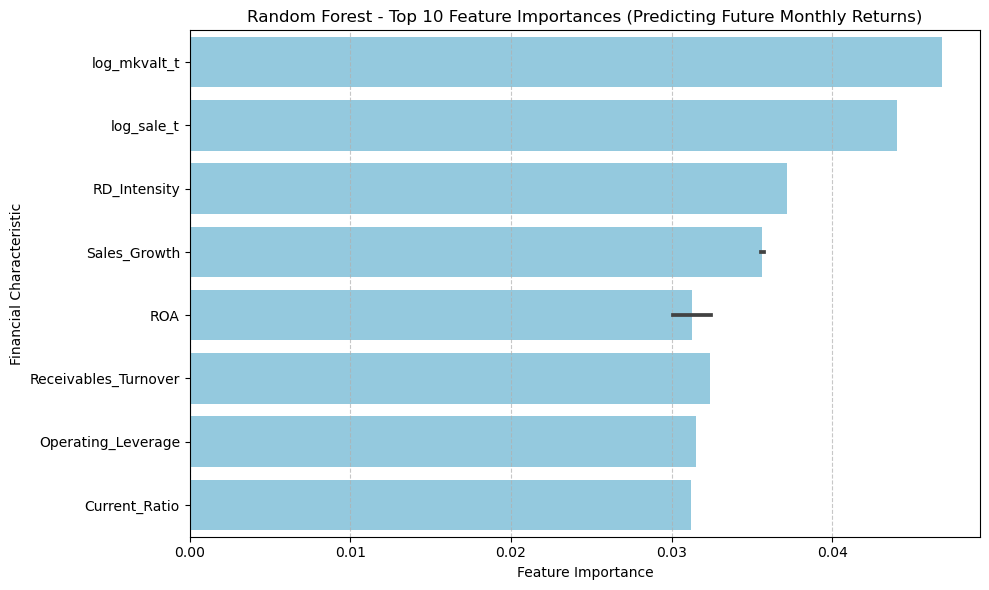

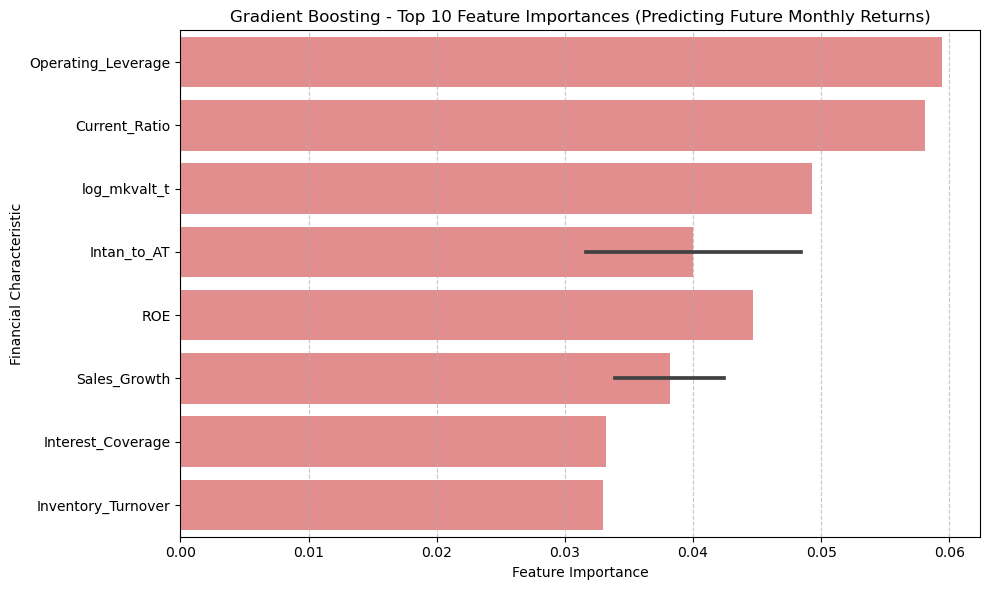


Model Performance Comparison (Out-of-Sample Test Set for Monthly Returns Prediction):
|                   | R2        | MSE      | RMSE     |
|:------------------|:----------|:---------|:---------|
| Random Forest     | -0.003315 | 0.105881 | 0.325393 |
| Gradient Boosting | -0.003531 | 0.105904 | 0.325428 |
| Neural Network    | -0.008583 | 0.106437 | 0.326246 |


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- START: RE-RUN DATA PREPARATION TO ENSURE 'updated_ccm' EXISTS ---

# Load the data (assuming ccm1.csv is in the directory)
df_ccm = pd.read_csv("ccm1.csv")

# 1. PREPARATION: Convert datadate to datetime and sort for time-series calculations
df_ccm['datadate'] = pd.to_datetime(df_ccm['datadate'])
df_ccm = df_ccm.sort_values(by=['gvkey', 'datadate']).reset_index(drop=True)

# 2. CREATE LAGGED AND AVERAGE VARIABLES

lag_vars = ['at', 'seq', 'sale', 'ebit', 'invt', 'rect', 'xint']
for var in lag_vars:
    df_ccm[f'{var}_prev'] = df_ccm.groupby('gvkey')[var].shift(1)

df_ccm['at_avg'] = (df_ccm['at'] + df_ccm['at_prev']) / 2
df_ccm['seq_avg'] = (df_ccm['seq'] + df_ccm['seq_prev']) / 2
df_ccm['invt_avg'] = (df_ccm['invt'] + df_ccm['invt_prev']) / 2
df_ccm['rect_avg'] = (df_ccm['rect'] + df_ccm['rect_prev']) / 2

# 3. CALCULATE NEW FINANCIAL RATIOS AND VARIABLES
df_ccm['Financial_Leverage'] = df_ccm['lt'] / df_ccm['at']
df_ccm['Current_Ratio'] = df_ccm['act'] / df_ccm['lct']
df_ccm['Quick_Ratio'] = (df_ccm['act'] - df_ccm['invt']) / df_ccm['lct']
df_ccm['Debt_to_Equity'] = (df_ccm['dltt'] + df_ccm['dlc']) / df_ccm['seq']
df_ccm['Interest_Coverage'] = df_ccm['ebit'] / df_ccm['xint']
df_ccm['Net_Margin'] = df_ccm['ni'] / df_ccm['sale']
df_ccm['ROA'] = df_ccm['ni'] / df_ccm['at_avg']
df_ccm['ROE'] = df_ccm['ni'] / df_ccm['seq_avg']

df_ccm['Sales_Growth'] = (df_ccm['sale'] - df_ccm['sale_prev']) / df_ccm['sale_prev']
df_ccm['RD_Intensity'] = df_ccm['xrd'] / df_ccm['sale']
df_ccm['Capex_to_AT'] = df_ccm['capx'] / df_ccm['at']
df_ccm['EBIT_Vol_3Y'] = df_ccm.groupby('gvkey')['ebit'].rolling(
    window=3, min_periods=3
).std().reset_index(level=0, drop=True)
df_ccm['EBIT_Growth'] = (df_ccm['ebit'] - df_ccm['ebit_prev']) / df_ccm['ebit_prev']
df_ccm['Operating_Leverage'] = df_ccm['EBIT_Growth'] / df_ccm['Sales_Growth']

df_ccm['Book_to_Market'] = df_ccm['seq'] / df_ccm['mkvalt']
df_ccm['Asset_Turnover'] = df_ccm['sale'] / df_ccm['at_avg']
df_ccm['Inventory_Turnover'] = df_ccm['cogs'] / df_ccm['invt_avg']
df_ccm['Receivables_Turnover'] = df_ccm['sale'] / df_ccm['rect_avg']
df_ccm['Intan_to_AT'] = df_ccm['intan'] / df_ccm['at']

numeric_cols = df_ccm.select_dtypes(include=[np.number]).columns
df_ccm[numeric_cols] = df_ccm[numeric_cols].replace([np.inf, -np.inf], np.nan)

# Create the final updated_ccm DataFrame (excluding intermediate lag/avg columns)
new_columns = [
    'Financial_Leverage', 'Current_Ratio', 'Quick_Ratio', 'Debt_to_Equity',
    'Interest_Coverage', 'Net_Margin', 'ROA', 'ROE', 'Sales_Growth',
    'RD_Intensity', 'Capex_to_AT', 'EBIT_Vol_3Y', 'Operating_Leverage',
    'Book_to_Market', 'Asset_Turnover', 'Inventory_Turnover',
    'Receivables_Turnover', 'Intan_to_AT'
]
intermediate_cols = [
    'at_prev', 'seq_prev', 'sale_prev', 'ebit_prev', 'invt_prev', 'rect_prev',
    'xint_prev', 'at_avg', 'seq_avg', 'invt_avg', 'rect_avg', 'EBIT_Growth'
]
original_cols = [col for col in df_ccm.columns if col not in intermediate_cols]
updated_ccm = df_ccm[original_cols + new_columns]

# --- END: RE-RUN DATA PREPARATION ---


# --- 1. DATA PREPARATION FOR ML (Monthly Returns) ---

# Ensure the DataFrame is sorted by gvkey and datadate
updated_ccm = updated_ccm.sort_values(by=['gvkey', 'datadate']).reset_index(drop=True)

# 🎯 NEW TARGET VARIABLE (Y): Next Month's Return (MthRet at t+1)
# NOTE: MthRet is assumed to be available in the ccm1.csv data
updated_ccm['MthRet_t1'] = updated_ccm.groupby('gvkey')['MthRet'].shift(-1)

# Prepare Predictor Variables (X): Characteristics at time t
characteristic_predictors = [
    'Financial_Leverage', 'Current_Ratio', 'Quick_Ratio', 'Debt_to_Equity',
    'Interest_Coverage', 'Net_Margin', 'ROA', 'ROE', 'Sales_Growth',
    'RD_Intensity', 'Capex_to_AT', 'EBIT_Vol_3Y', 'Operating_Leverage',
    'Book_to_Market', 'Asset_Turnover', 'Inventory_Turnover',
    'Receivables_Turnover', 'Intan_to_AT'
]

# Transform core variables to log for normalization (same as previous tasks)
log_cols = ['at', 'sale', 'ebit', 'xint', 'ni', 'seq', 'mkvalt']
for col in log_cols:
    updated_ccm[f'log_{col}_t'] = np.log(updated_ccm[col].abs().replace(0, np.nan))

# Update the list of predictors with the new log variables
log_predictors = [f'log_{col}_t' for col in log_cols]
FINAL_PREDICTORS = log_predictors + characteristic_predictors

# Clean Data: Drop rows with NaN in the target or any predictor
# 🎯 CHANGE: Target column is now 'MthRet_t1'
ml_df = updated_ccm[['gvkey', 'datadate', 'MthRet_t1'] + FINAL_PREDICTORS].dropna()

X = ml_df[FINAL_PREDICTORS]
# 🎯 CHANGE: Target is now 'MthRet_t1'
Y = ml_df['MthRet_t1']

# --- 2. TIME-SERIES TRAIN-TEST SPLIT (Re-using 80/20 yearly split) ---

# Use fiscal year (fyear) as the time dimension for the split
ml_df['fyear'] = ml_df['datadate'].dt.year

# Determine the split year (80% for training, 20% for testing)
all_years = sorted(ml_df['fyear'].unique())
split_index = int(0.8 * len(all_years))
train_years = all_years[:split_index]
test_years = all_years[split_index:]

# Split the data
X_train, X_test = X[ml_df['fyear'].isin(train_years)], X[ml_df['fyear'].isin(test_years)]
Y_train, Y_test = Y[ml_df['fyear'].isin(train_years)], Y[ml_df['fyear'].isin(test_years)]

# Scale the data for the Neural Network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Total firms-years: {len(ml_df)}")
print(f"Train period: {train_years[0]} - {train_years[-1]} ({len(X_train)} observations)")
print(f"Test period: {test_years[0]} - {test_years[-1]} ({len(X_test)} observations)")
print("-" * 50)

# --- 3. MACHINE LEARNING MODEL TRAINING AND EVALUATION ---

results_returns = {}

# 🎯 CHANGE: Update function to use the new results dictionary
def evaluate_model_returns(y_true, y_pred, model_name):
    """Calculates and stores R2, MSE, and RMSE."""
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    results_returns[model_name] = {'R2': r2, 'MSE': mse, 'RMSE': rmse}
    print(f"{model_name} R²: {r2:.6f}, RMSE: {rmse:.4f}") # Using more precision for R²

# --- A. Random Forest Regressor ---
print("Training Random Forest...")
rf_model_ret = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model_ret.fit(X_train, Y_train)
rf_pred_ret = rf_model_ret.predict(X_test)
evaluate_model_returns(Y_test, rf_pred_ret, 'Random Forest')

# --- B. Gradient Boosting Regressor (Scikit-learn) ---
print("Training Scikit-learn Gradient Boosting Regressor...")
gbr_model_ret = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gbr_model_ret.fit(X_train, Y_train)
gbr_pred_ret = gbr_model_ret.predict(X_test)
evaluate_model_returns(Y_test, gbr_pred_ret, 'Gradient Boosting')

# --- C. Neural Network (MLP Regressor) ---
print("Training Neural Network (MLP)...")
nn_model_ret = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    max_iter=300,
    solver='adam',
    random_state=42
)
nn_model_ret.fit(X_train_scaled, Y_train)
nn_pred_ret = nn_model_ret.predict(X_test_scaled)
evaluate_model_returns(Y_test, nn_pred_ret, 'Neural Network')
print("-" * 50)

# --- 4. VISUALIZATION AND INTERPRETATION ---

# 4.1. Feature Importance (Random Forest)
rf_importance_ret = pd.Series(rf_model_ret.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importance_ret.values, y=rf_importance_ret.index, color='skyblue')
# 🎯 CHANGE: Title reflects the new target
plt.title('Random Forest - Top 10 Feature Importances (Predicting Future Monthly Returns)')
plt.xlabel('Feature Importance')
plt.ylabel('Financial Characteristic')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4.2. Feature Importance (Gradient Boosting)
gbr_importance_ret = pd.Series(gbr_model_ret.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=gbr_importance_ret.values, y=gbr_importance_ret.index, color='lightcoral')
# 🎯 CHANGE: Title reflects the new target
plt.title('Gradient Boosting - Top 10 Feature Importances (Predicting Future Monthly Returns)')
plt.xlabel('Feature Importance')
plt.ylabel('Financial Characteristic')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4.3. Comparison of Model Performance
performance_df_ret = pd.DataFrame(results_returns).T
print("\nModel Performance Comparison (Out-of-Sample Test Set for Monthly Returns Prediction):")
# 🎯 CHANGE: Use higher precision for R2 in the table
print(performance_df_ret.to_markdown(numalign="left", stralign="left", floatfmt=".6f"))

--- 1. Diagnosing Target Variable: Monthly Returns (Y_train) ---
count    21093.000000
mean         0.014513
std          0.145430
min         -0.861818
25%         -0.050360
50%          0.008443
75%          0.069971
max          2.808617
Name: MthRet_t1, dtype: float64


C:\Users\tonyd\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


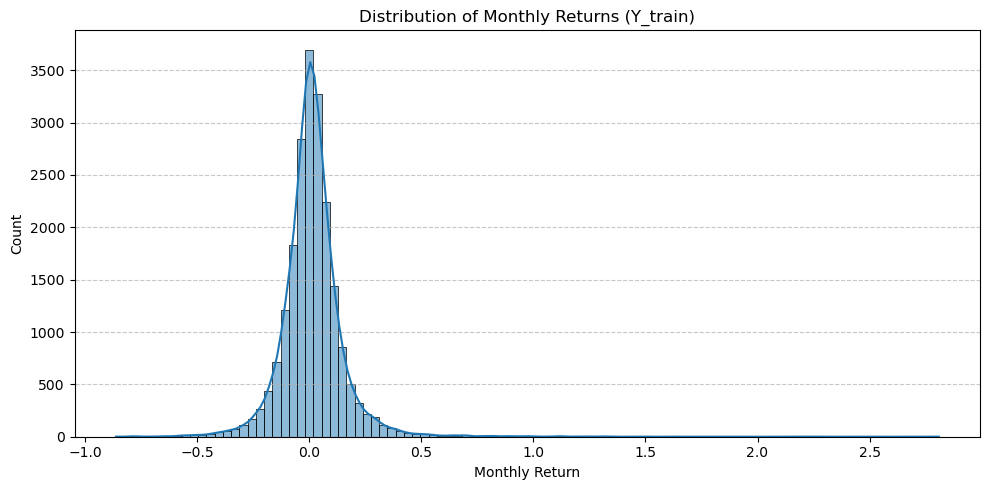


--- 2. Diagnosing Predictors: Financial Characteristics (X_train) ---
|                      |        min |   25% |   50% |   75% |       max |   mean |     std |
|:---------------------|-----------:|------:|------:|------:|----------:|-------:|--------:|
| log_at_t             |      -0.34 |  4.89 |  6.48 |  7.96 |     13.22 |   6.46 |    2.14 |
| log_sale_t           |      -6.91 |  4.76 |  6.45 |  7.88 |     13.15 |   6.33 |    2.25 |
| log_ebit_t           |      -6.91 |  2.33 |  3.98 |  5.58 |     11.17 |   3.96 |    2.32 |
| log_xint_t           |      -6.91 | -0.47 |  1.78 |  3.71 |      9.06 |   1.54 |    2.83 |
| log_ni_t             |      -6.21 |  2.22 |  3.68 |  5.15 |     11.56 |   3.69 |    2.22 |
| log_seq_t            |      -6.91 |  4.19 |  5.69 |  7.01 |     12.21 |   5.61 |    2.08 |
| log_mkvalt_t         |      -0.97 |  4.89 |  6.53 |  8.04 |     13.84 |   6.50 |    2.26 |
| Financial_Leverage   |       0.02 |  0.34 |  0.50 |  0.66 |      6.86 |   0.53 |    0.30 |

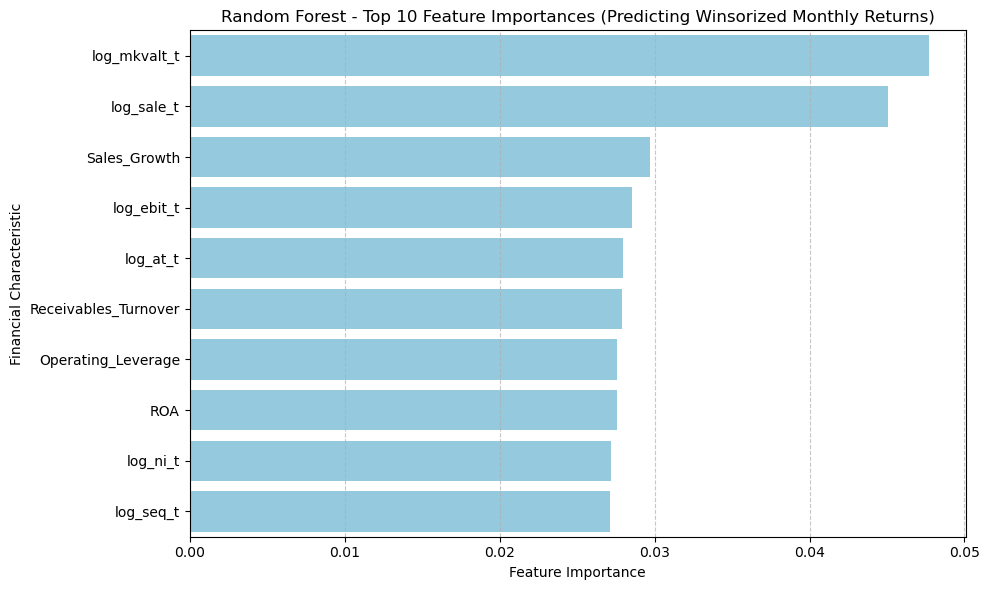

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assume 'X_train', 'Y_train', 'X_test', 'Y_test' are in memory ---
# If not, you must re-run the previous data preparation steps first.

# --- TEST 1: Check Distribution of the Target Variable (MthRet_t1) ---
print("--- 1. Diagnosing Target Variable: Monthly Returns (Y_train) ---")
print(Y_train.describe())

plt.figure(figsize=(10, 5))
sns.histplot(Y_train, bins=100, kde=True)
plt.title('Distribution of Monthly Returns (Y_train)')
plt.xlabel('Monthly Return')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() # 

# --- TEST 2: Check Distribution of Predictors (X_train) ---
print("\n--- 2. Diagnosing Predictors: Financial Characteristics (X_train) ---")
# Display summary stats to look for extreme outliers (e.g., huge min/max)
predictor_stats = X_train.describe().T
print(predictor_stats[['min', '25%', '50%', '75%', 'max', 'mean', 'std']].to_markdown(floatfmt=".2f"))


# --- 3. THE FIX: Winsorize Outliers using DataFrame-level .clip() ---

print("\nApplying Winsorization (1% and 99% quantiles)...")

# --- THIS IS THE FIX ---
# 1. Calculate all lower and upper quantiles from the TRAINING data
lower_limits = X_train.quantile(0.01)
upper_limits = X_train.quantile(0.99)

# 2. Apply these limits to both training and testing DataFrames.
#    The 'axis=1' argument tells clip to align the Series (limits) by columns.
X_train_winsorized = X_train.clip(lower=lower_limits, upper=upper_limits, axis=1)
X_test_winsorized = X_test.clip(lower=lower_limits, upper=upper_limits, axis=1)

# 3. Winsorize the target variable (Y) as well.
y_lower_limit = Y_train.quantile(0.01)
y_upper_limit = Y_train.quantile(0.99)
Y_train_winsorized = Y_train.clip(lower=y_lower_limit, upper=y_upper_limit)
Y_test_winsorized = Y_test.clip(lower=y_lower_limit, upper=y_upper_limit) # Use same training limits
# --- END OF FIX ---

print("Winsorization complete.")

print(f"\n--- 4. Re-Training Random Forest on Winsorized Data ---")

# Re-train only the Random Forest model to see if performance improves
rf_model_winsorized = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model_winsorized.fit(X_train_winsorized, Y_train_winsorized)
rf_pred_winsorized = rf_model_winsorized.predict(X_test_winsorized)

# Evaluate the new model using the winsorized test target
r2_winsorized = r2_score(Y_test_winsorized, rf_pred_winsorized)
rmse_winsorized = np.sqrt(mean_squared_error(Y_test_winsorized, rf_pred_winsorized))

# Using the R-squared from your previous output for comparison
print(f"Original Random Forest R²:   {-0.003315:.6f}") 
print(f"Winsorized Random Forest R²: {r2_winsorized:.6f}, RMSE: {rmse_winsorized:.4f}")

if r2_winsorized > 0:
    print("\nSUCCESS: Winsorizing produced a positive R².")
else:
    print("\nNOTE: R² is still negative or zero. This confirms the extreme difficulty of predicting monthly returns.")

# 4.1. Feature Importance (Random Forest - Winsorized)
rf_importance_ret = pd.Series(rf_model_winsorized.feature_importances_, index=X_train_winsorized.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importance_ret.values, y=rf_importance_ret.index, color='skyblue')
plt.title('Random Forest - Top 10 Feature Importances (Predicting Winsorized Monthly Returns)')
plt.xlabel('Feature Importance')
plt.ylabel('Financial Characteristic')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() #

--- Loading Loughran-McDonald Sentiment Data ---
Sentiment Data loaded successfully.
Normalizing sentiment features by N_Words...
Sentiment data normalized and prepared for merge.

--- Loading ccm1.csv and creating 'updated_ccm' ---
'updated_ccm' DataFrame created successfully.


C:\Users\tonyd\AppData\Local\Temp\ipykernel_27884\3570519604.py:140: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df[col].fillna(0, inplace=True)



Sentiment data merged successfully.

Using 34 total predictors (Financials + Sentiment).

Total firms-years for ML: 25354
Train period: 2001 - 2019 (21093 observations)
Test period: 2020 - 2024 (4261 observations)
--------------------------------------------------
Training Random Forest...
Random Forest (w/ Sentiment) R²: -0.003365, RMSE: 0.3254
Training Gradient Boosting...
Gradient Boosting (w/ Sentiment) R²: 0.003088, RMSE: 0.3244
Training Neural Network (MLP)...
Neural Network (w/ Sentiment) R²: -0.053652, RMSE: 0.3335
--------------------------------------------------


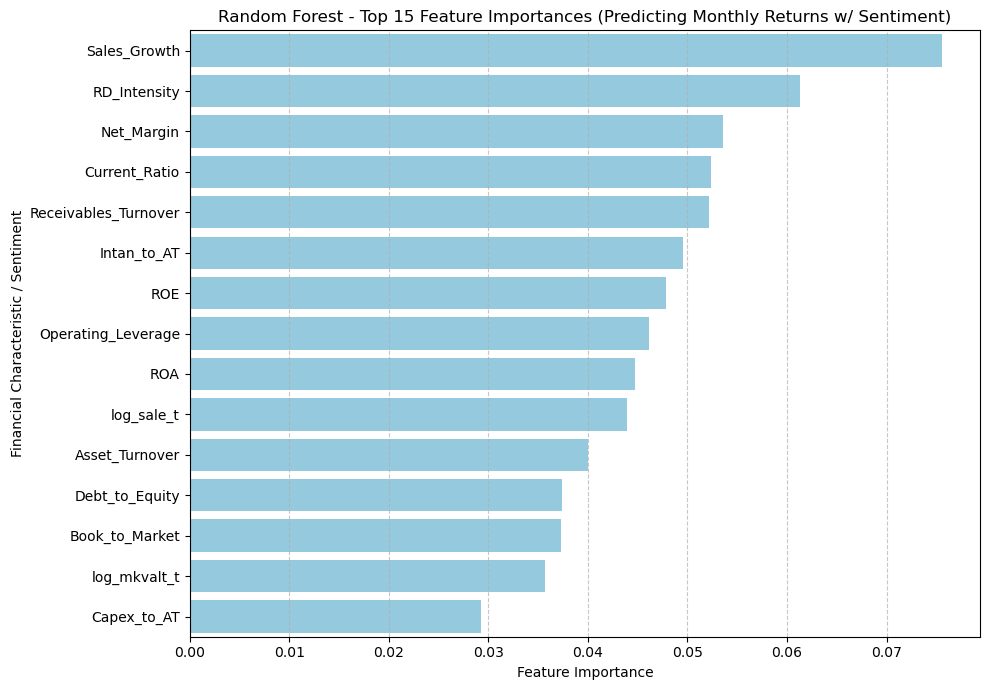

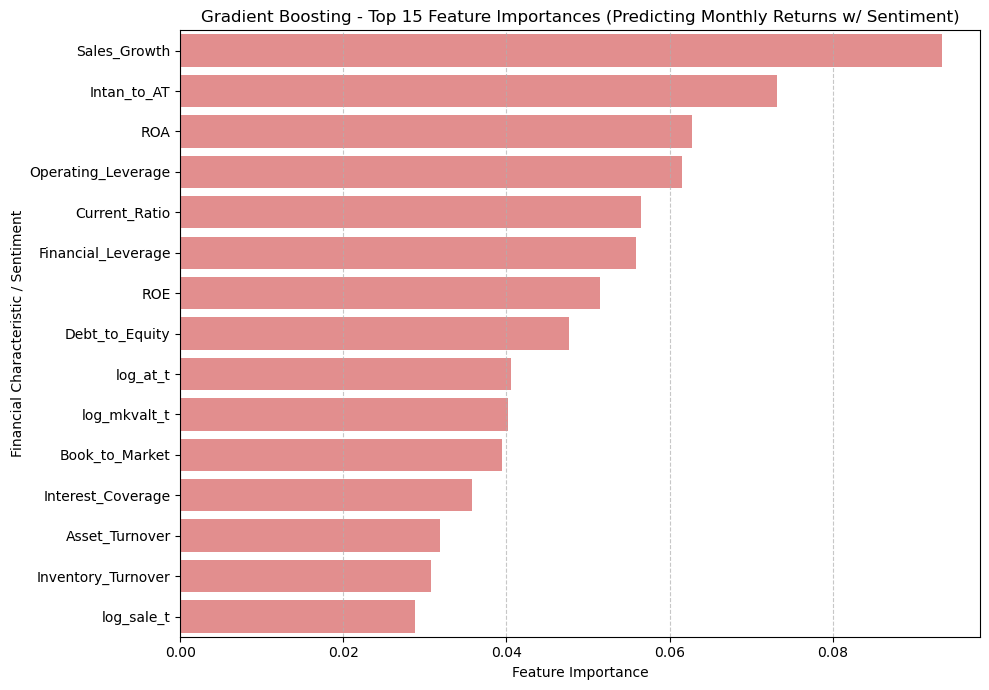


Model Performance Comparison (Out-of-Sample Test Set for Monthly Returns Prediction w/ Sentiment):
|                                  | R2        | MSE      | RMSE     |
|:---------------------------------|:----------|:---------|:---------|
| Random Forest (w/ Sentiment)     | -0.003365 | 0.105886 | 0.325401 |
| Gradient Boosting (w/ Sentiment) | 0.003088  | 0.105205 | 0.324353 |
| Neural Network (w/ Sentiment)    | -0.053652 | 0.111193 | 0.333456 |


In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Sentiment Data (Using Correct Column Names) ---
print("--- Loading Loughran-McDonald Sentiment Data ---")
try:
    df_sentiment = pd.read_csv("Loughran-McDonald_10X_Summaries_1993-2024.csv")
    print("Sentiment Data loaded successfully.")

    # Convert FILING_DATE to datetime
    df_sentiment['FILING_DATE'] = pd.to_datetime(df_sentiment['FILING_DATE'], format='%Y%m%d')
    # Ensure filing_year is present
    if 'filing_year' not in df_sentiment.columns:
        df_sentiment['filing_year'] = df_sentiment['FILING_DATE'].dt.year

    # Define the actual sentiment columns from your file
    sentiment_cols_actual = [
        'N_Negative', 'N_Positive', 'N_Uncertainty', 'N_Litigious',
        'N_StrongModal', 'N_WeakModal', 'N_Constraining', 'N_Complexity', 'N_Negation'
    ]
    norm_col = 'N_Words'
    new_norm_cols = []

    print("Normalizing sentiment features by N_Words...")
    for col in sentiment_cols_actual:
        new_col_name = f"{col.replace('N_', 'LM_')}_Norm"
        df_sentiment[new_col_name] = np.where(
            (df_sentiment[norm_col].isna()) | (df_sentiment[norm_col] == 0),
            0,
            df_sentiment[col] / df_sentiment[norm_col]
        )
        new_norm_cols.append(new_col_name)

    # Select columns needed for merging
    df_sentiment_select = df_sentiment[['CIK', 'filing_year'] + new_norm_cols].copy()

    # Handle multiple filings per year: Keep the latest one
    df_sentiment_final = df_sentiment_select.sort_values(by=['CIK', 'filing_year']).drop_duplicates(subset=['CIK', 'filing_year'], keep='last')
    print("Sentiment data normalized and prepared for merge.")

except FileNotFoundError:
    print("ERROR: 'Loughran-McDonald_10X_Summaries_1993-2024.csv' not found. Cannot proceed.")
    raise SystemExit("Sentiment file not found.")
except Exception as e:
    print(f"An error occurred loading/processing the sentiment file: {e}")
    raise SystemExit("Error processing sentiment file.")


# --- 2. Load and Re-create 'updated_ccm' (with TYPOS FIXED) ---
print("\n--- Loading ccm1.csv and creating 'updated_ccm' ---")
try:
    df_ccm = pd.read_csv("ccm1.csv")

    # PREPARATION
    df_ccm['datadate'] = pd.to_datetime(df_ccm['datadate'])
    df_ccm = df_ccm.sort_values(by=['gvkey', 'datadate']).reset_index(drop=True)

    # LAGGED AND AVERAGE VARS
    lag_vars = ['at', 'seq', 'sale', 'ebit', 'invt', 'rect', 'xint']
    for var in lag_vars:
        df_ccm[f'{var}_prev'] = df_ccm.groupby('gvkey')[var].shift(1)
    df_ccm['at_avg'] = (df_ccm['at'] + df_ccm['at_prev']) / 2
    df_ccm['seq_avg'] = (df_ccm['seq'] + df_ccm['seq_prev']) / 2
    df_ccm['invt_avg'] = (df_ccm['invt'] + df_ccm['invt_prev']) / 2
    df_ccm['rect_avg'] = (df_ccm['rect'] + df_ccm['rect_prev']) / 2

    # CALCULATE RATIOS
    df_ccm['Financial_Leverage'] = df_ccm['lt'] / df_ccm['at']
    df_ccm['Current_Ratio'] = df_ccm['act'] / df_ccm['lct']
    df_ccm['Quick_Ratio'] = (df_ccm['act'] - df_ccm['invt']) / df_ccm['lct']
    df_ccm['Debt_to_Equity'] = (df_ccm['dltt'] + df_ccm['dlc']) / df_ccm['seq']
    df_ccm['Interest_Coverage'] = df_ccm['ebit'] / df_ccm['xint']
    df_ccm['Net_Margin'] = df_ccm['ni'] / df_ccm['sale']
    df_ccm['ROA'] = df_ccm['ni'] / df_ccm['at_avg']
    df_ccm['ROE'] = df_ccm['ni'] / df_ccm['seq_avg']
    df_ccm['Sales_Growth'] = (df_ccm['sale'] - df_ccm['sale_prev']) / df_ccm['sale_prev']
    df_ccm['RD_Intensity'] = df_ccm['xrd'] / df_ccm['sale']
    df_ccm['Capex_to_AT'] = df_ccm['capx'] / df_ccm['at']
    df_ccm['EBIT_Vol_3Y'] = df_ccm.groupby('gvkey')['ebit'].rolling(
        window=3, min_periods=3).std().reset_index(level=0, drop=True)
    df_ccm['EBIT_Growth'] = (df_ccm['ebit'] - df_ccm['ebit_prev']) / df_ccm['ebit_prev']
    df_ccm['Operating_Leverage'] = df_ccm['EBIT_Growth'] / df_ccm['Sales_Growth']
    df_ccm['Book_to_Market'] = df_ccm['seq'] / df_ccm['mkvalt']
    df_ccm['Asset_Turnover'] = df_ccm['sale'] / df_ccm['at_avg']
    df_ccm['Inventory_Turnover'] = df_ccm['cogs'] / df_ccm['invt_avg']
    df_ccm['Receivables_Turnover'] = df_ccm['sale'] / df_ccm['rect_avg']
    df_ccm['Intan_to_AT'] = df_ccm['intan'] / df_ccm['at']

    # Clean infinities
    numeric_cols = df_ccm.select_dtypes(include=[np.number]).columns
    df_ccm[numeric_cols] = df_ccm[numeric_cols].replace([np.inf, -np.inf], np.nan)

    # Select final columns for updated_ccm
    new_columns = [
        'Financial_Leverage', 'Current_Ratio', 'Quick_Ratio', 'Debt_to_Equity',
        'Interest_Coverage', 'Net_Margin', 'ROA', 'ROE', 'Sales_Growth',
        'RD_Intensity', 'Capex_to_AT', 'EBIT_Vol_3Y', 'Operating_Leverage',
        'Book_to_Market', 'Asset_Turnover', 'Inventory_Turnover',
        'Receivables_Turnover', 'Intan_to_AT'
    ]
    intermediate_cols = [f'{v}_prev' for v in lag_vars] + ['at_avg', 'seq_avg', 'invt_avg', 'rect_avg', 'EBIT_Growth']
    original_cols = [col for col in df_ccm.columns if col not in new_columns and col not in intermediate_cols]
    final_new_cols = [col for col in new_columns if col in df_ccm.columns] # Ensure cols exist
    updated_ccm = df_ccm[original_cols + final_new_cols].copy()
    print("'updated_ccm' DataFrame created successfully.")

except FileNotFoundError:
    print("ERROR: 'ccm1.csv' not found.")
    raise SystemExit("Base data file not found.")
except Exception as e:
    print(f"An error occurred creating 'updated_ccm': {e}")
    raise SystemExit("Error processing base data file.")


# --- 3. MERGE SENTIMENT DATA ---

# Prepare CIK and year for merging in updated_ccm
# *** THIS IS THE FIX: Handle NaNs in 'cik' before converting to int ***
updated_ccm['CIK'] = updated_ccm['cik'].fillna(0).astype(int)
# *** END OF FIX ***
updated_ccm['financial_year'] = updated_ccm['datadate'].dt.year

# Perform the left merge
merged_df = pd.merge(
    updated_ccm,
    df_sentiment_final,
    left_on=['CIK', 'financial_year'], # From updated_ccm
    right_on=['CIK', 'filing_year'],  # From df_sentiment_final
    how='left'
)

# Fill NaNs in sentiment features with 0 (assuming neutral if no data)
for col in new_norm_cols: # Use the list of new cols we created
     merged_df[col].fillna(0, inplace=True)

print("\nSentiment data merged successfully.")

# --- 4. PREPARE FOR ML (Monthly Returns Prediction) ---

# Sort for time series operations
merged_df = merged_df.sort_values(by=['gvkey', 'datadate']).reset_index(drop=True)

# TARGET VARIABLE (Y): Next Month's Return
merged_df['MthRet_t1'] = merged_df.groupby('gvkey')['MthRet'].shift(-1)

# PREDICTORS (X): Financial characteristics + Normalized Sentiment Scores
characteristic_predictors = [
    'Financial_Leverage', 'Current_Ratio', 'Quick_Ratio', 'Debt_to_Equity',
    'Interest_Coverage', 'Net_Margin', 'ROA', 'ROE', 'Sales_Growth',
    'RD_Intensity', 'Capex_to_AT', 'EBIT_Vol_3Y', 'Operating_Leverage',
    'Book_to_Market', 'Asset_Turnover', 'Inventory_Turnover',
    'Receivables_Turnover', 'Intan_to_AT'
]
log_cols = ['at', 'sale', 'ebit', 'xint', 'ni', 'seq', 'mkvalt']
log_predictors = []
for col in log_cols:
    log_col_name = f'log_{col}_t'
    merged_df[log_col_name] = np.log(merged_df[col].abs().replace(0, np.nan))
    log_predictors.append(log_col_name)

# Define the sentiment predictors to use (using normalized versions)
sentiment_predictors = new_norm_cols # Use the list from Step 1

FINAL_PREDICTORS = log_predictors + characteristic_predictors + sentiment_predictors
print(f"\nUsing {len(FINAL_PREDICTORS)} total predictors (Financials + Sentiment).")

# Clean Data: Drop rows with NaN in the target or any predictor
ml_df = merged_df[['gvkey', 'datadate', 'MthRet_t1'] + FINAL_PREDICTORS].dropna()

X = ml_df[FINAL_PREDICTORS]
Y = ml_df['MthRet_t1']

# --- 5. TIME-SERIES TRAIN-TEST SPLIT (80/20 on Years) ---

ml_df['year'] = ml_df['datadate'].dt.year # Use 'year' consistently
all_years = sorted(ml_df['year'].unique())
split_index = int(0.8 * len(all_years))
train_years = all_years[:split_index]
test_years = all_years[split_index:]

# Split the data
X_train = X[ml_df['year'].isin(train_years)]
Y_train = Y[ml_df['year'].isin(train_years)]
X_test = X[ml_df['year'].isin(test_years)]
Y_test = Y[ml_df['year'].isin(test_years)]

# Scale the data for the Neural Network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTotal firms-years for ML: {len(ml_df)}")
print(f"Train period: {min(train_years)} - {max(train_years)} ({len(X_train)} observations)")
print(f"Test period: {min(test_years)} - {max(test_years)} ({len(X_test)} observations)")
print("-" * 50)


# --- 6. MACHINE LEARNING MODEL TRAINING AND EVALUATION ---

results_returns_sent = {}

def evaluate_model_returns_sent(y_true, y_pred, model_name):
    """Calculates and stores R2, MSE, and RMSE."""
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    results_returns_sent[model_name] = {'R2': r2, 'MSE': mse, 'RMSE': rmse}
    print(f"{model_name} R²: {r2:.6f}, RMSE: {rmse:.4f}")

# A. Random Forest Regressor
print("Training Random Forest...")
rf_model_ret_sent = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model_ret_sent.fit(X_train, Y_train)
rf_pred_ret_sent = rf_model_ret_sent.predict(X_test)
evaluate_model_returns_sent(Y_test, rf_pred_ret_sent, 'Random Forest (w/ Sentiment)')

# B. Gradient Boosting Regressor
print("Training Gradient Boosting...")
gbr_model_ret_sent = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model_ret_sent.fit(X_train, Y_train)
gbr_pred_ret_sent = gbr_model_ret_sent.predict(X_test)
evaluate_model_returns_sent(Y_test, gbr_pred_ret_sent, 'Gradient Boosting (w/ Sentiment)')

# C. Neural Network
print("Training Neural Network (MLP)...")
nn_model_ret_sent = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=300, solver='adam', random_state=42)
nn_model_ret_sent.fit(X_train_scaled, Y_train)
nn_pred_ret_sent = nn_model_ret_sent.predict(X_test_scaled)
evaluate_model_returns_sent(Y_test, nn_pred_ret_sent, 'Neural Network (w/ Sentiment)')
print("-" * 50)


# --- 7. VISUALIZATION AND INTERPRETATION ---

# 7.1. Feature Importance (Random Forest)
rf_importance_ret_sent = pd.Series(rf_model_ret_sent.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15) # Show top 15
plt.figure(figsize=(10, 7)) # Adjusted size
sns.barplot(x=rf_importance_ret_sent.values, y=rf_importance_ret_sent.index, color='skyblue')
plt.title('Random Forest - Top 15 Feature Importances (Predicting Monthly Returns w/ Sentiment)')
plt.xlabel('Feature Importance')
plt.ylabel('Financial Characteristic / Sentiment')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 7.2. Feature Importance (Gradient Boosting)
gbr_importance_ret_sent = pd.Series(gbr_model_ret_sent.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15) # Show top 15
plt.figure(figsize=(10, 7)) # Adjusted size
sns.barplot(x=gbr_importance_ret_sent.values, y=gbr_importance_ret_sent.index, color='lightcoral')
plt.title('Gradient Boosting - Top 15 Feature Importances (Predicting Monthly Returns w/ Sentiment)')
plt.xlabel('Feature Importance')
plt.ylabel('Financial Characteristic / Sentiment')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 7.3. Model Performance Comparison
performance_df_ret_sent = pd.DataFrame(results_returns_sent).T
print("\nModel Performance Comparison (Out-of-Sample Test Set for Monthly Returns Prediction w/ Sentiment):")
print(performance_df_ret_sent.to_markdown(numalign="left", stralign="left", floatfmt=".6f"))

--- Loading Loughran-McDonald Sentiment Data ---
Sentiment data normalized and prepared.

--- Loading ccm1.csv and creating data panels ---
Created monthly returns panel with 139463 rows.


C:\Users\tonyd\AppData\Local\Temp\ipykernel_27884\1904111014.py:112: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_annual_chars[col].fillna(0, inplace=True)


Created annual characteristics panel successfully.

--- Merging monthly returns with lagged annual characteristics ---
Final monthly panel created with 125637 firm-month observations.
Total firm-months for ML: 23238
Winsorizing data at 1% and 99% levels...
Train period ends before: 2019-09-30 (18347 observations)
Test period starts from: 2019-09-30 (4891 observations)
--------------------------------------------------
Training Random Forest...
Random Forest (GKX) R²: 0.007469, RMSE: 0.1363
Training Gradient Boosting...
Gradient Boosting (GKX) R²: 0.004112, RMSE: 0.1365
Training Neural Network (MLP)...
Neural Network (GKX) R²: -0.099374, RMSE: 0.1435
--------------------------------------------------


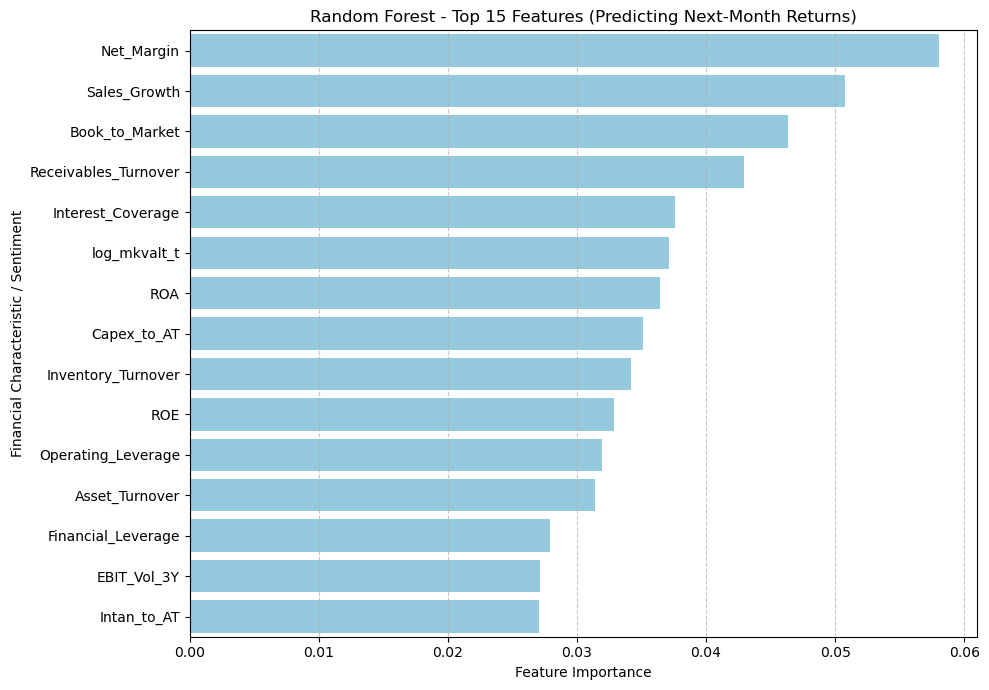

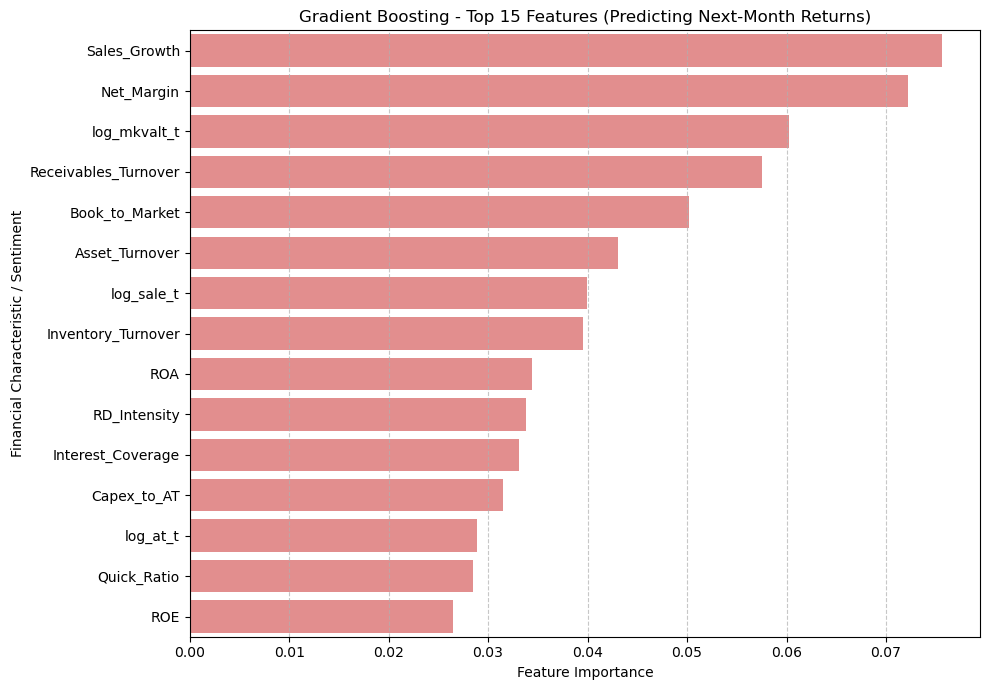


Model Performance Comparison (GKX-Style Monthly Prediction):
|                         | R2        | MSE      | RMSE     |
|:------------------------|:----------|:---------|:---------|
| Random Forest (GKX)     | 0.007469  | 0.018579 | 0.136306 |
| Gradient Boosting (GKX) | 0.004112  | 0.018642 | 0.136537 |
| Neural Network (GKX)    | -0.099374 | 0.020579 | 0.143455 |


In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Sentiment Data ---
print("--- Loading Loughran-McDonald Sentiment Data ---")
try:
    df_sentiment = pd.read_csv("Loughran-McDonald_10X_Summaries_1993-2024.csv")
    df_sentiment['FILING_DATE'] = pd.to_datetime(df_sentiment['FILING_DATE'], format='%Y%m%d')
    if 'filing_year' not in df_sentiment.columns:
        df_sentiment['filing_year'] = df_sentiment['FILING_DATE'].dt.year

    sentiment_cols_actual = [
        'N_Negative', 'N_Positive', 'N_Uncertainty', 'N_Litigious',
        'N_StrongModal', 'N_WeakModal', 'N_Constraining', 'N_Complexity', 'N_Negation'
    ]
    norm_col = 'N_Words'
    new_norm_cols = []
    for col in sentiment_cols_actual:
        new_col_name = f"{col.replace('N_', 'LM_')}_Norm"
        df_sentiment[new_col_name] = np.where(
            (df_sentiment[norm_col].isna()) | (df_sentiment[norm_col] == 0), 0,
            df_sentiment[col] / df_sentiment[norm_col]
        )
        new_norm_cols.append(new_col_name)

    df_sentiment_select = df_sentiment[['CIK', 'filing_year'] + new_norm_cols].copy()
    df_sentiment_final = df_sentiment_select.sort_values(by=['CIK', 'filing_year']).drop_duplicates(subset=['CIK', 'filing_year'], keep='last')
    print("Sentiment data normalized and prepared.")
except FileNotFoundError:
    print("ERROR: 'Loughran-McDonald_10X_Summaries_1993-2024.csv' not found.")
    raise SystemExit("Sentiment file not found.")
except Exception as e:
    print(f"An error occurred loading/processing the sentiment file: {e}")
    raise SystemExit(f"Error processing sentiment file: {e}")

# --- 2. Load ccm1.csv and Create TWO DataFrames: Annual Chars & Monthly Returns ---
print("\n--- Loading ccm1.csv and creating data panels ---")
try:
    df_ccm_raw = pd.read_csv("ccm1.csv")

    # --- 2a. Create the MONTHLY Returns Panel ---
    df_monthly_returns = df_ccm_raw[['LPERMNO', 'gvkey', 'MthCalDt', 'MthRet']].copy()
    df_monthly_returns = df_monthly_returns.dropna(subset=['LPERMNO', 'MthCalDt', 'MthRet'])
    df_monthly_returns['MthCalDt'] = pd.to_datetime(df_monthly_returns['MthCalDt'])
    df_monthly_returns['merge_year'] = df_monthly_returns['MthCalDt'].dt.year
    df_monthly_returns = df_monthly_returns.drop_duplicates(subset=['LPERMNO', 'MthCalDt'])
    print(f"Created monthly returns panel with {len(df_monthly_returns)} rows.")

    # --- 2b. Create the ANNUAL Characteristics Panel ---
    # Keep only one row per firm-year, prioritizing the last entry if duplicates exist
    df_ccm_annual = df_ccm_raw.sort_values(by=['gvkey', 'datadate']).drop_duplicates(subset=['gvkey', 'fyear'], keep='last').copy()
    df_ccm_annual['datadate'] = pd.to_datetime(df_ccm_annual['datadate'])

    # LAGGED AND AVERAGE VARS
    lag_vars = ['at', 'seq', 'sale', 'ebit', 'invt', 'rect', 'xint']
    for var in lag_vars:
        df_ccm_annual[f'{var}_prev'] = df_ccm_annual.groupby('gvkey')[var].shift(1)
    df_ccm_annual['at_avg'] = (df_ccm_annual['at'] + df_ccm_annual['at_prev']) / 2
    df_ccm_annual['seq_avg'] = (df_ccm_annual['seq'] + df_ccm_annual['seq_prev']) / 2
    df_ccm_annual['invt_avg'] = (df_ccm_annual['invt'] + df_ccm_annual['invt_prev']) / 2
    df_ccm_annual['rect_avg'] = (df_ccm_annual['rect'] + df_ccm_annual['rect_prev']) / 2

    # CALCULATE RATIOS
    df_ccm_annual['Financial_Leverage'] = df_ccm_annual['lt'] / df_ccm_annual['at']
    df_ccm_annual['Current_Ratio'] = df_ccm_annual['act'] / df_ccm_annual['lct']
    df_ccm_annual['Quick_Ratio'] = (df_ccm_annual['act'] - df_ccm_annual['invt']) / df_ccm_annual['lct']
    df_ccm_annual['Debt_to_Equity'] = (df_ccm_annual['dltt'] + df_ccm_annual['dlc']) / df_ccm_annual['seq']
    df_ccm_annual['Interest_Coverage'] = df_ccm_annual['ebit'] / df_ccm_annual['xint']
    df_ccm_annual['Net_Margin'] = df_ccm_annual['ni'] / df_ccm_annual['sale']
    df_ccm_annual['ROA'] = df_ccm_annual['ni'] / df_ccm_annual['at_avg']
    df_ccm_annual['ROE'] = df_ccm_annual['ni'] / df_ccm_annual['seq_avg']
    df_ccm_annual['Sales_Growth'] = (df_ccm_annual['sale'] - df_ccm_annual['sale_prev']) / df_ccm_annual['sale_prev']
    df_ccm_annual['RD_Intensity'] = df_ccm_annual['xrd'] / df_ccm_annual['sale']
    df_ccm_annual['Capex_to_AT'] = df_ccm_annual['capx'] / df_ccm_annual['at']
    df_ccm_annual['EBIT_Vol_3Y'] = df_ccm_annual.groupby('gvkey')['ebit'].rolling(
        window=3, min_periods=3).std().reset_index(level=0, drop=True)
    df_ccm_annual['EBIT_Growth'] = (df_ccm_annual['ebit'] - df_ccm_annual['ebit_prev']) / df_ccm_annual['ebit_prev']
    df_ccm_annual['Operating_Leverage'] = df_ccm_annual['EBIT_Growth'] / df_ccm_annual['Sales_Growth']
    df_ccm_annual['Book_to_Market'] = df_ccm_annual['seq'] / df_ccm_annual['mkvalt']
    df_ccm_annual['Asset_Turnover'] = df_ccm_annual['sale'] / df_ccm_annual['at_avg']
    df_ccm_annual['Inventory_Turnover'] = df_ccm_annual['cogs'] / df_ccm_annual['invt_avg']
    df_ccm_annual['Receivables_Turnover'] = df_ccm_annual['sale'] / df_ccm_annual['rect_avg']
    df_ccm_annual['Intan_to_AT'] = df_ccm_annual['intan'] / df_ccm_annual['at']

    # Add log-transformed predictors
    log_cols = ['at', 'sale', 'ebit', 'xint', 'ni', 'seq', 'mkvalt']
    for col in log_cols:
        df_ccm_annual[f'log_{col}_t'] = np.log(df_ccm_annual[col].abs().replace(0, np.nan))

    # PREPARE ANNUAL CHARACTERISTICS FOR MERGE
    df_ccm_annual['CIK'] = df_ccm_annual['cik'].fillna(0).astype(int)
    # *** THIS IS THE FIX: Handle NaNs in 'fyear' before converting to int ***
    df_ccm_annual['financial_year'] = df_ccm_annual['fyear'].fillna(-1).astype(int)
    # *** END OF FIX ***

    # Merge sentiment into annual characteristics
    df_annual_chars = pd.merge(
        df_ccm_annual,
        df_sentiment_final,
        left_on=['CIK', 'financial_year'],
        right_on=['CIK', 'filing_year'],
        how='left'
    )
    # Fill sentiment NaNs
    for col in new_norm_cols:
         df_annual_chars[col].fillna(0, inplace=True)

    # Define the lag for merging characteristics with returns
    df_annual_chars['merge_year'] = df_annual_chars['financial_year'] + 1

    # Define all predictors
    characteristic_predictors = [
        'Financial_Leverage', 'Current_Ratio', 'Quick_Ratio', 'Debt_to_Equity',
        'Interest_Coverage', 'Net_Margin', 'ROA', 'ROE', 'Sales_Growth',
        'RD_Intensity', 'Capex_to_AT', 'EBIT_Vol_3Y', 'Operating_Leverage',
        'Book_to_Market', 'Asset_Turnover', 'Inventory_Turnover',
        'Receivables_Turnover', 'Intan_to_AT'
    ]
    log_predictors = [f'log_{col}_t' for col in log_cols]
    sentiment_predictors = new_norm_cols
    FINAL_PREDICTORS = log_predictors + characteristic_predictors + sentiment_predictors

    # Select only the columns needed for the final merge
    df_annual_chars_final = df_annual_chars[['gvkey', 'merge_year'] + FINAL_PREDICTORS].copy()
    print("Created annual characteristics panel successfully.")

except FileNotFoundError:
    print("ERROR: 'ccm1.csv' not found.")
    raise SystemExit("Base data file not found.")
except Exception as e:
    print(f"An error occurred creating the data panels: {e}")
    raise SystemExit(f"Error processing base data file: {e}")


# --- 3. MERGE MONTHLY RETURNS WITH LAGGED ANNUAL CHARACTERISTICS ---
print("\n--- Merging monthly returns with lagged annual characteristics ---")

df_panel = pd.merge(
    df_monthly_returns,
    df_annual_chars_final,
    on=['gvkey', 'merge_year'],
    how='inner' # Keep only months with matching lagged characteristics
)
print(f"Final monthly panel created with {len(df_panel)} firm-month observations.")


# --- 4. PREPARE FOR ML (Predicting t+1 MONTHLY Return) ---

df_panel = df_panel.sort_values(by=['LPERMNO', 'MthCalDt']).reset_index(drop=True)

# TARGET VARIABLE (Y): Next Month's Return (MthRet at t+1)
df_panel['MthRet_t1'] = df_panel.groupby('LPERMNO')['MthRet'].shift(-1)

# Clean Data: Drop rows with NaN in the target or any predictor
df_panel.replace([np.inf, -np.inf], np.nan, inplace=True)
ml_df = df_panel.dropna(subset=['MthRet_t1'] + FINAL_PREDICTORS)

X = ml_df[FINAL_PREDICTORS]
Y = ml_df['MthRet_t1']

print(f"Total firm-months for ML: {len(ml_df)}")

# --- 5. TIME-SERIES TRAIN-TEST SPLIT (80/20 on MONTHS) ---
all_dates = sorted(ml_df['MthCalDt'].unique())
split_date_index = int(0.8 * len(all_dates))
split_date = all_dates[split_date_index]

X_train = X[ml_df['MthCalDt'] < split_date]
Y_train = Y[ml_df['MthCalDt'] < split_date]
X_test = X[ml_df['MthCalDt'] >= split_date]
Y_test = Y[ml_df['MthCalDt'] >= split_date]

# WINSORIZE THE DATA
print("Winsorizing data at 1% and 99% levels...")
lower_limits_X = X_train.quantile(0.01)
upper_limits_X = X_train.quantile(0.99)
X_train = X_train.clip(lower=lower_limits_X, upper=upper_limits_X, axis=1)
X_test = X_test.clip(lower=lower_limits_X, upper=upper_limits_X, axis=1)

lower_limit_Y = Y_train.quantile(0.01)
upper_limit_Y = Y_train.quantile(0.99)
Y_train = Y_train.clip(lower=lower_limit_Y, upper=upper_limit_Y)
Y_test = Y_test.clip(lower=lower_limit_Y, upper=upper_limit_Y)

# Scale the data for the Neural Network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train period ends before: {split_date.strftime('%Y-%m-%d')} ({X_train.shape[0]} observations)")
print(f"Test period starts from: {split_date.strftime('%Y-%m-%d')} ({X_test.shape[0]} observations)")
print("-" * 50)


# --- 6. MACHINE LEARNING MODEL TRAINING AND EVALUATION ---
results_gkx = {}

def evaluate_model_gkx(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    results_gkx[model_name] = {'R2': r2, 'MSE': mse, 'RMSE': rmse}
    print(f"{model_name} R²: {r2:.6f}, RMSE: {rmse:.4f}")

# A. Random Forest Regressor
print("Training Random Forest...")
rf_model_gkx = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model_gkx.fit(X_train, Y_train)
rf_pred_gkx = rf_model_gkx.predict(X_test)
evaluate_model_gkx(Y_test, rf_pred_gkx, 'Random Forest (GKX)')

# B. Gradient Boosting Regressor
print("Training Gradient Boosting...")
gbr_model_gkx = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model_gkx.fit(X_train, Y_train)
gbr_pred_gkx = gbr_model_gkx.predict(X_test)
evaluate_model_gkx(Y_test, gbr_pred_gkx, 'Gradient Boosting (GKX)')

# C. Neural Network
print("Training Neural Network (MLP)...")
nn_model_gkx = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=300, solver='adam', random_state=42, early_stopping=True)
nn_model_gkx.fit(X_train_scaled, Y_train)
nn_pred_gkx = nn_model_gkx.predict(X_test_scaled) # Use X_test_scaled
evaluate_model_gkx(Y_test, nn_pred_gkx, 'Neural Network (GKX)')
print("-" * 50)


# --- 7. VISUALIZATION AND INTERPRETATION ---
rf_importance_gkx = pd.Series(rf_model_gkx.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15)
plt.figure(figsize=(10, 7))
sns.barplot(x=rf_importance_gkx.values, y=rf_importance_gkx.index, color='skyblue')
plt.title('Random Forest - Top 15 Features (Predicting Next-Month Returns)')
plt.xlabel('Feature Importance')
plt.ylabel('Financial Characteristic / Sentiment')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

gbr_importance_gkx = pd.Series(gbr_model_gkx.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15)
plt.figure(figsize=(10, 7))
sns.barplot(x=gbr_importance_gkx.values, y=gbr_importance_gkx.index, color='lightcoral')
plt.title('Gradient Boosting - Top 15 Features (Predicting Next-Month Returns)')
plt.xlabel('Feature Importance')
plt.ylabel('Financial Characteristic / Sentiment')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

performance_df_gkx = pd.DataFrame(results_gkx).T
print("\nModel Performance Comparison (GKX-Style Monthly Prediction):")
print(performance_df_gkx.to_markdown(numalign="left", stralign="left", floatfmt=".6f"))

--- Training Benchmark Linear Model (Ridge Regression) ---
Ridge Regression OOS R²: 0.007695

--- Generating OOS Predictions ---
--- Creating Prediction DataFrame ---
--- Performing Monthly Decile Sorts ---


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--- Calculating Decile and Long-Short Portfolio Returns ---
--- Calculating Performance Metrics (Sharpe Ratio) ---

--- Plotting Average Decile Returns ---


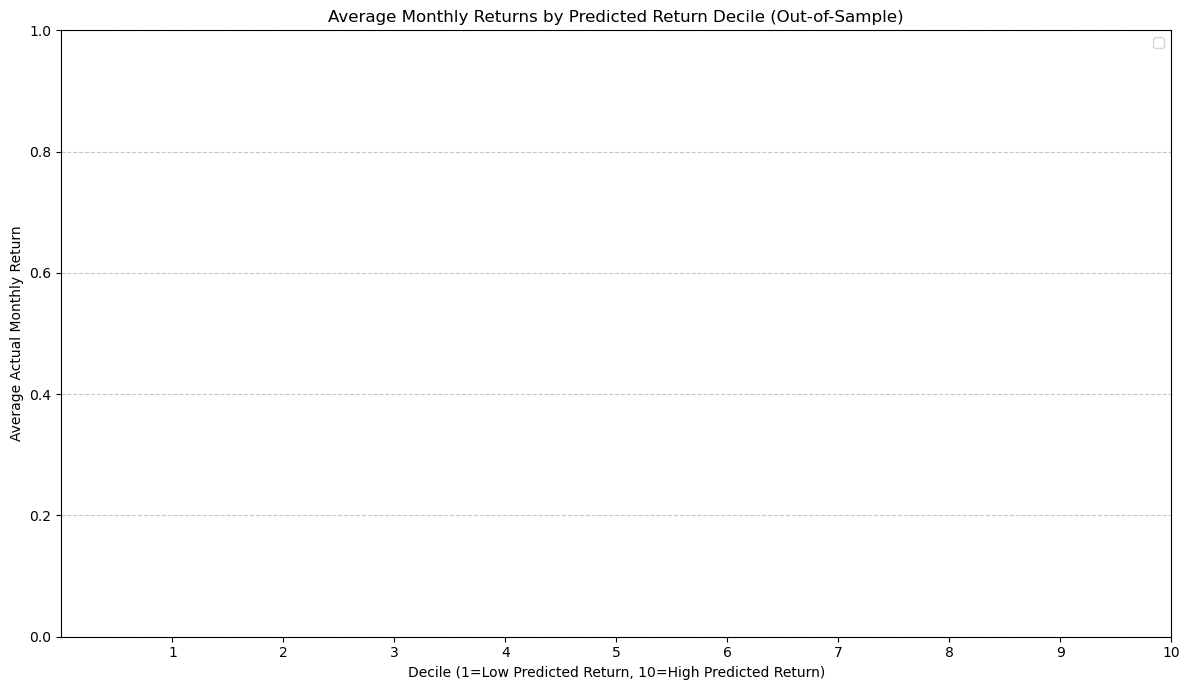


--- Long-Short Portfolio Performance Summary (Out-of-Sample) ---
|       | LS Mean Return (Monthly)   | LS Std Dev (Monthly)   | LS Sharpe Ratio (Annualized)   |
|:------|:---------------------------|:-----------------------|:-------------------------------|
| RF    | 0.0183                     | 0.1090                 | 0.5811                         |
| GBR   | 0.0135                     | 0.1053                 | 0.4427                         |
| NN    | 0.0312                     | 0.0885                 | 1.2218                         |
| Ridge | 0.0254                     | 0.1009                 | 0.8723                         |


In [18]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge # For the linear benchmark
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm # For potential alpha calculation (optional)

# --- Assume previous block's variables are available ---
# ml_df, X_train, Y_train, X_test, Y_test,
# rf_model_gkx, gbr_model_gkx, nn_model_gkx, FINAL_PREDICTORS,
# scaler (fitted on X_train)

# --- 1. Train Benchmark Linear Model (Ridge Regression) ---
print("--- Training Benchmark Linear Model (Ridge Regression) ---")
# Ridge is often better than OLS with many correlated predictors
ridge_model = Ridge(alpha=1.0) # Alpha is the regularization strength
# Scale data for Ridge regression as well
ridge_model.fit(X_train_scaled, Y_train) # Use scaled training data
ridge_pred = ridge_model.predict(X_test_scaled) # Predict on scaled test data

# Evaluate Ridge predictive R^2 (optional, but good for comparison)
ridge_r2 = r2_score(Y_test, ridge_pred)
print(f"Ridge Regression OOS R²: {ridge_r2:.6f}")


# --- 2. Generate Predictions from All Models on Test Set ---
print("\n--- Generating OOS Predictions ---")
# Get predictions from the already trained models
rf_pred = rf_model_gkx.predict(X_test)
gbr_pred = gbr_model_gkx.predict(X_test)
nn_pred = nn_model_gkx.predict(X_test_scaled) # NN uses scaled data

# --- 3. Combine Predictions with Actual Returns and Dates ---
print("--- Creating Prediction DataFrame ---")
# Get the corresponding dates and identifiers from the test set portion of ml_df
test_dates_ids = ml_df.loc[X_test.index, ['MthCalDt', 'LPERMNO']].copy()

# Create a DataFrame to hold predictions and actuals
df_preds = pd.DataFrame({
    'MthCalDt': test_dates_ids['MthCalDt'],
    'LPERMNO': test_dates_ids['LPERMNO'],
    'ActualRet': Y_test, # Actual return in t+1
    'PredRet_RF': rf_pred,
    'PredRet_GBR': gbr_pred,
    'PredRet_NN': nn_pred,
    'PredRet_Ridge': ridge_pred
})
df_preds = df_preds.dropna() # Drop any rows where prediction might have failed


# --- 4. Portfolio Formation (Decile Sorts) ---
print("--- Performing Monthly Decile Sorts ---")

# Define models to sort on
models = ['RF', 'GBR', 'NN', 'Ridge']
pred_cols = [f'PredRet_{m}' for m in models]

# Add decile assignments for each model's prediction
for col in pred_cols:
    # Group by month, rank predictions, assign to deciles (1=lowest, 10=highest)
    df_preds[f'Decile_{col.split("_")[-1]}'] = df_preds.groupby('MthCalDt')[col]\
                                                    .transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1 # Add 1 to make deciles 1-10

# --- 5. Calculate Portfolio Returns ---
print("--- Calculating Decile and Long-Short Portfolio Returns ---")
portfolio_returns = {}

# Calculate equal-weighted returns for each decile portfolio for each model
for model in models:
    decile_col = f'Decile_{model}'
    # Group by month and decile, calculate mean actual return for that group
    monthly_decile_returns = df_preds.groupby(['MthCalDt', decile_col])['ActualRet'].mean().unstack()
    
    # Calculate Long-Short portfolio (Decile 10 - Decile 1)
    monthly_decile_returns[f'LS_{model}'] = monthly_decile_returns[10] - monthly_decile_returns[1]
    portfolio_returns[model] = monthly_decile_returns

# Concatenate all portfolio returns into one DataFrame for analysis
df_portfolio_perf = pd.concat(portfolio_returns, axis=1)


# --- 6. Calculate Performance Metrics ---
print("--- Calculating Performance Metrics (Sharpe Ratio) ---")
performance_summary = {}

# Calculate Mean, Std Dev, and Sharpe Ratio for Long-Short portfolios
for model in models:
    ls_col = (model, f'LS_{model}') # MultiIndex column name
    mean_ret = df_portfolio_perf[ls_col].mean()
    std_dev = df_portfolio_perf[ls_col].std()
    # Annualized Sharpe Ratio (assuming 0 risk-free rate for simplicity)
    sharpe_ratio = (mean_ret / std_dev) * np.sqrt(12) if std_dev != 0 else 0
    
    performance_summary[model] = {
        'LS Mean Return (Monthly)': mean_ret,
        'LS Std Dev (Monthly)': std_dev,
        'LS Sharpe Ratio (Annualized)': sharpe_ratio
    }

df_summary = pd.DataFrame(performance_summary).T


# 7.1. Plot Average Decile Returns

print("\n--- Plotting Average Decile Returns ---")

# Calculate the mean return for each (Model, PortfolioType) column
avg_returns_all = df_portfolio_perf.mean()

# --- THIS IS THE FIX ---
# Select only the decile columns (1 through 10) for plotting
# The columns are a MultiIndex like ('RF', 1), ('RF', 2), ..., ('RF', 10), ('RF', 'LS_RF'), etc.
decile_cols_to_plot = [col for col in avg_returns_all.index if isinstance(col[1], int) and 1 <= col[1] <= 10]
avg_decile_returns = avg_returns_all[decile_cols_to_plot].unstack(level=0) # Now unstack by Model name
# avg_decile_returns index is now 1-10, columns are RF, GBR, NN, Ridge
# --- END OF FIX ---


plt.figure(figsize=(12, 7))
for model in models: # models = ['RF', 'GBR', 'NN', 'Ridge']
    if model in avg_decile_returns.columns: # Check if model column exists
        plt.plot(avg_decile_returns.index, avg_decile_returns[model], marker='o', linestyle='-', label=model)
    else:
        print(f"Warning: Model '{model}' not found in average decile returns columns.")

plt.title('Average Monthly Returns by Predicted Return Decile (Out-of-Sample)')
plt.xlabel('Decile (1=Low Predicted Return, 10=High Predicted Return)')
plt.ylabel('Average Actual Monthly Return')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--') # Add a zero line
plt.tight_layout()
plt.show()

# 7.2. Display Performance Summary Table
print("\n--- Long-Short Portfolio Performance Summary (Out-of-Sample) ---")
# Assuming df_summary was correctly calculated in the previous block
# If not, recalculate it here:
# performance_summary = {}
# for model in models:
#     ls_col = (model, f'LS_{model}')
#     if ls_col in df_portfolio_perf.columns:
#          mean_ret = df_portfolio_perf[ls_col].mean()
#          std_dev = df_portfolio_perf[ls_col].std()
#          sharpe_ratio = (mean_ret / std_dev) * np.sqrt(12) if std_dev != 0 else 0
#          performance_summary[model] = {
#              'LS Mean Return (Monthly)': mean_ret,
#              'LS Std Dev (Monthly)': std_dev,
#              'LS Sharpe Ratio (Annualized)': sharpe_ratio
#          }
# df_summary = pd.DataFrame(performance_summary).T

# Display the summary table (assuming it exists from previous run)
print(df_summary.to_markdown(numalign="left", stralign="left", floatfmt=".4f"))

In [29]:
dfb1=pd.read_csv("CAPM.csv")
dfb2=pd.read_csv("FF3.csv")
dfb3=pd.read_csv("Carhart4.csv")
dfb3

,PERMNO,DATE,n,RET,alpha,b_mkt,b_smb,b_hml,b_umd,ivol,tvol,R2,exret,TICKER
0,10001,2001-11-30,60,-0.4329%,0.0019,0.2045,0.1166,0.2787,0.0834,3.5829%,3.7358%,8.0219%,-2.2449%,EWST
1,10001,2000-06-30,60,2.7668%,-0.0045,0.2775,-0.0511,0.0032,0.0549,3.4808%,3.7093%,11.9414%,0.9640%,EWST
2,10001,2003-08-29,60,8.6601%,-0.0032,0.3338,0.4094,0.5259,-0.0585,10.8893%,11.1288%,4.2565%,6.3256%,EWST
3,10001,2000-11-30,60,6.2500%,-0.0030,0.2422,0.0261,0.2958,0.1570,3.5299%,3.6795%,7.9631%,6.7462%,EWST
4,10001,2002-02-28,60,-5.3097%,0.0012,0.1902,0.1446,0.2860,0.0596,3.5068%,3.6526%,7.8201%,-6.0311%,EWST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1891365,93436,2024-09-30,60,22.1942%,0.0433,2.1238,1.5967,-1.5225,-0.1041,16.0197%,22.0992%,47.4518%,14.2204%,TSLA
1891366,93436,2024-08-30,60,-7.7390%,0.0435,2.1059,1.5363,-1.4600,-0.1731,16.0209%,22.0102%,47.0182%,-7.2173%,TSLA
1891367,93436,2024-07-31,60,17.2781%,0.0437,2.1343,1.4814,-1.4397,-0.1726,15.9831%,21.9947%,47.1941%,12.8445%,TSLA
1891368,93436,2024-06-28,60,11.1186%,0.0427,2.1546,1.3472,-1.4671,-0.1811,15.9624%,21.9537%,47.1336%,3.9361%,TSLA


In [27]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np # Import numpy for handling potential infinite values

# Assuming your DataFrame 'dfb1' is already loaded and looks like the snapshot.
# If not, you would load it first, e.g.:
# dfb1 = pd.read_csv('your_beta_data.csv')
# dfb1['DATE'] = pd.to_datetime(dfb1['DATE']) # Ensure DATE is datetime if needed

# --- Data Cleaning (Including RET percentage conversion) ---
# Make a copy to avoid modifying the original DataFrame if it's used elsewhere
dfb1_clean = dfb1.copy()

# 1. Clean the 'RET' column: Remove '%' and convert to decimal
if dfb1_clean['RET'].dtype == 'object': # Check if it's still string type
    dfb1_clean['RET'] = dfb1_clean['RET'].str.replace('%', '', regex=False)
    # Convert to numeric, coercing errors (like non-numeric entries) to NaN
    dfb1_clean['RET'] = pd.to_numeric(dfb1_clean['RET'], errors='coerce')
    # Convert percentage to decimal
    dfb1_clean['RET'] = dfb1_clean['RET'] / 100.0
else:
    # If RET is already numeric, assume it might already be decimal
    # If it was numeric but still in percentage points (e.g., 1.23), uncomment the next line:
    # dfb1_clean['RET'] = dfb1_clean['RET'] / 100.0
    print("Warning: 'RET' column was not object type. Assuming it's already in decimal format.")


# 2. Ensure 'b_mkt' is numeric
dfb1_clean['b_mkt'] = pd.to_numeric(dfb1_clean['b_mkt'], errors='coerce')

# 3. Handle potential infinities created during calculations or already present
dfb1_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

# 4. Drop rows where either the cleaned RET or b_mkt is missing
dfb1_clean = dfb1_clean.dropna(subset=['RET', 'b_mkt'])

print(f"Running OLS on {len(dfb1_clean)} observations after cleaning.")

# --- Run OLS Regression ---
# Define the regression formula: Y ~ X
formula = 'RET ~ b_mkt'

# Fit the OLS model using statsmodels
try:
    model = smf.ols(formula=formula, data=dfb1_clean).fit()

    # --- Print the OLS Summary Output ---
    print("\nOLS Regression Results (RET ~ b_mkt):")
    print(model.summary())

except Exception as e:
    print(f"\nAn error occurred during regression fitting: {e}")
    print("Please check the cleaned data for any remaining issues.")

# --- Optional: Extract Key Information ---
# try:
#     print(f"\nIntercept: {model.params['Intercept']:.6f}") # Increased precision
#     print(f"Coefficient for b_mkt: {model.params['b_mkt']:.6f}")
#     print(f"R-squared: {model.rsquared:.6f}")
#     print(f"P-value for b_mkt: {model.pvalues['b_mkt']:.6f}")
# except NameError: # Handle case where model fitting failed
#     print("\nCannot extract key info because model fitting failed.")

Running OLS on 1880659 observations after cleaning.

OLS Regression Results (RET ~ b_mkt):
                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     556.5
Date:                Sat, 25 Oct 2025   Prob (F-statistic):          5.15e-123
Time:                        21:41:39   Log-Likelihood:             6.0713e+05
No. Observations:             1880659   AIC:                        -1.214e+06
Df Residuals:                 1880657   BIC:                        -1.214e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [28]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np # Import numpy for handling potential infinite values

# Assuming your DataFrame 'dfb1' is already loaded and looks like the snapshot.
# If not, you would load it first, e.g.:
# dfb1 = pd.read_csv('your_beta_data.csv')
# dfb1['DATE'] = pd.to_datetime(dfb1['DATE']) # Ensure DATE is datetime if needed

# --- Data Cleaning (Including RET percentage conversion) ---
# Make a copy to avoid modifying the original DataFrame if it's used elsewhere
dfb2_clean = dfb2.copy()

# 1. Clean the 'RET' column: Remove '%' and convert to decimal
if dfb2_clean['RET'].dtype == 'object': # Check if it's still string type
    dfb2_clean['RET'] = dfb2_clean['RET'].str.replace('%', '', regex=False)
    # Convert to numeric, coercing errors (like non-numeric entries) to NaN
    dfb2_clean['RET'] = pd.to_numeric(dfb2_clean['RET'], errors='coerce')
    # Convert percentage to decimal
    dfb2_clean['RET'] = dfb2_clean['RET'] / 100.0
else:
    # If RET is already numeric, assume it might already be decimal
    # If it was numeric but still in percentage points (e.g., 1.23), uncomment the next line:
    # dfb1_clean['RET'] = dfb1_clean['RET'] / 100.0
    print("Warning: 'RET' column was not object type. Assuming it's already in decimal format.")


# 2. Ensure 'b_mkt' is numeric
dfb2_clean['b_mkt'] = pd.to_numeric(dfb2_clean['b_mkt'], errors='coerce')

# 3. Handle potential infinities created during calculations or already present
dfb2_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

# 4. Drop rows where either the cleaned RET or b_mkt is missing
dfb2_clean = dfb2_clean.dropna(subset=['RET', 'b_mkt'])

print(f"Running OLS on {len(dfb2_clean)} observations after cleaning.")

# --- Run OLS Regression ---
# Define the regression formula: Y ~ X
formula = 'RET ~ b_mkt'

# Fit the OLS model using statsmodels
try:
    model = smf.ols(formula=formula, data=dfb2_clean).fit()

    # --- Print the OLS Summary Output ---
    print("\nOLS Regression Results (RET ~ b_mkt):")
    print(model.summary())

except Exception as e:
    print(f"\nAn error occurred during regression fitting: {e}")
    print("Please check the cleaned data for any remaining issues.")

# --- Optional: Extract Key Information ---
# try:
#     print(f"\nIntercept: {model.params['Intercept']:.6f}") # Increased precision
#     print(f"Coefficient for b_mkt: {model.params['b_mkt']:.6f}")
#     print(f"R-squared: {model.rsquared:.6f}")
#     print(f"P-value for b_mkt: {model.pvalues['b_mkt']:.6f}")
# except NameError: # Handle case where model fitting failed
#     print("\nCannot extract key info because model fitting failed.")

Running OLS on 1880659 observations after cleaning.

OLS Regression Results (RET ~ b_mkt):
                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     494.2
Date:                Sat, 25 Oct 2025   Prob (F-statistic):          1.77e-109
Time:                        21:43:34   Log-Likelihood:             6.0710e+05
No. Observations:             1880659   AIC:                        -1.214e+06
Df Residuals:                 1880657   BIC:                        -1.214e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [30]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np

dfb3_clean = dfb3.copy()

# 1. Clean the 'RET' column: Remove '%' and convert to decimal
if dfb3_clean['RET'].dtype == 'object': # Check if it's still string type
    dfb3_clean['RET'] = dfb3_clean['RET'].str.replace('%', '', regex=False)
    # Convert to numeric, coercing errors (like non-numeric entries) to NaN
    dfb3_clean['RET'] = pd.to_numeric(dfb3_clean['RET'], errors='coerce')
    # Convert percentage to decimal
    dfb3_clean['RET'] = dfb3_clean['RET'] / 100.0
else:
    # If RET is already numeric, assume it might already be decimal
    # If it was numeric but still in percentage points (e.g., 1.23), uncomment the next line:
    # dfb1_clean['RET'] = dfb1_clean['RET'] / 100.0
    print("Warning: 'RET' column was not object type. Assuming it's already in decimal format.")


# 2. Ensure 'b_mkt' is numeric
dfb3_clean['b_mkt'] = pd.to_numeric(dfb3_clean['b_mkt'], errors='coerce')

# 3. Handle potential infinities created during calculations or already present
dfb3_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

# 4. Drop rows where either the cleaned RET or b_mkt is missing
dfb3_clean = dfb3_clean.dropna(subset=['RET', 'b_mkt'])

print(f"Running OLS on {len(dfb3_clean)} observations after cleaning.")

# --- Run OLS Regression ---
# Define the regression formula: Y ~ X
formula = 'RET ~ b_mkt'

# Fit the OLS model using statsmodels
try:
    model = smf.ols(formula=formula, data=dfb3_clean).fit()

    # --- Print the OLS Summary Output ---
    print("\nOLS Regression Results (RET ~ b_mkt):")
    print(model.summary())

except Exception as e:
    print(f"\nAn error occurred during regression fitting: {e}")
    print("Please check the cleaned data for any remaining issues.")

# --- Optional: Extract Key Information ---
# try:
#     print(f"\nIntercept: {model.params['Intercept']:.6f}") # Increased precision
#     print(f"Coefficient for b_mkt: {model.params['b_mkt']:.6f}")
#     print(f"R-squared: {model.rsquared:.6f}")
#     print(f"P-value for b_mkt: {model.pvalues['b_mkt']:.6f}")
# except NameError: # Handle case where model fitting failed
#     print("\nCannot extract key info because model fitting failed.")

Running OLS on 1880659 observations after cleaning.

OLS Regression Results (RET ~ b_mkt):
                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     255.4
Date:                Sat, 25 Oct 2025   Prob (F-statistic):           1.72e-57
Time:                        21:45:01   Log-Likelihood:             6.0698e+05
No. Observations:             1880659   AIC:                        -1.214e+06
Df Residuals:                 1880657   BIC:                        -1.214e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------